# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

In [82]:
import os
import shutil
import tqdm
import math
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
import statsmodels.formula.api as smf
from typing import List, Set, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [4]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

In [5]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""
7475335,2010-01-01 00:14:00,1684,2140,26.46,"""Online Transaction""",39021,"""ONLINE""",null,null,"""4784""",null,"""Tolls and Bridge Fees""","""No""",56,65,1963,11,"""Male""","""27019 Madison Lane""",36.34,-83.28,13668.0,27861.0,108313.0,782,5,"""Mastercard""","""Debit (Prepaid)""",5955075527372953,"""05/2021""",513,"""YES""",1,46.0,"""03/2007""",2012,"""No"""


In [6]:
df.shape

(8472184, 38)

In [7]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [8]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

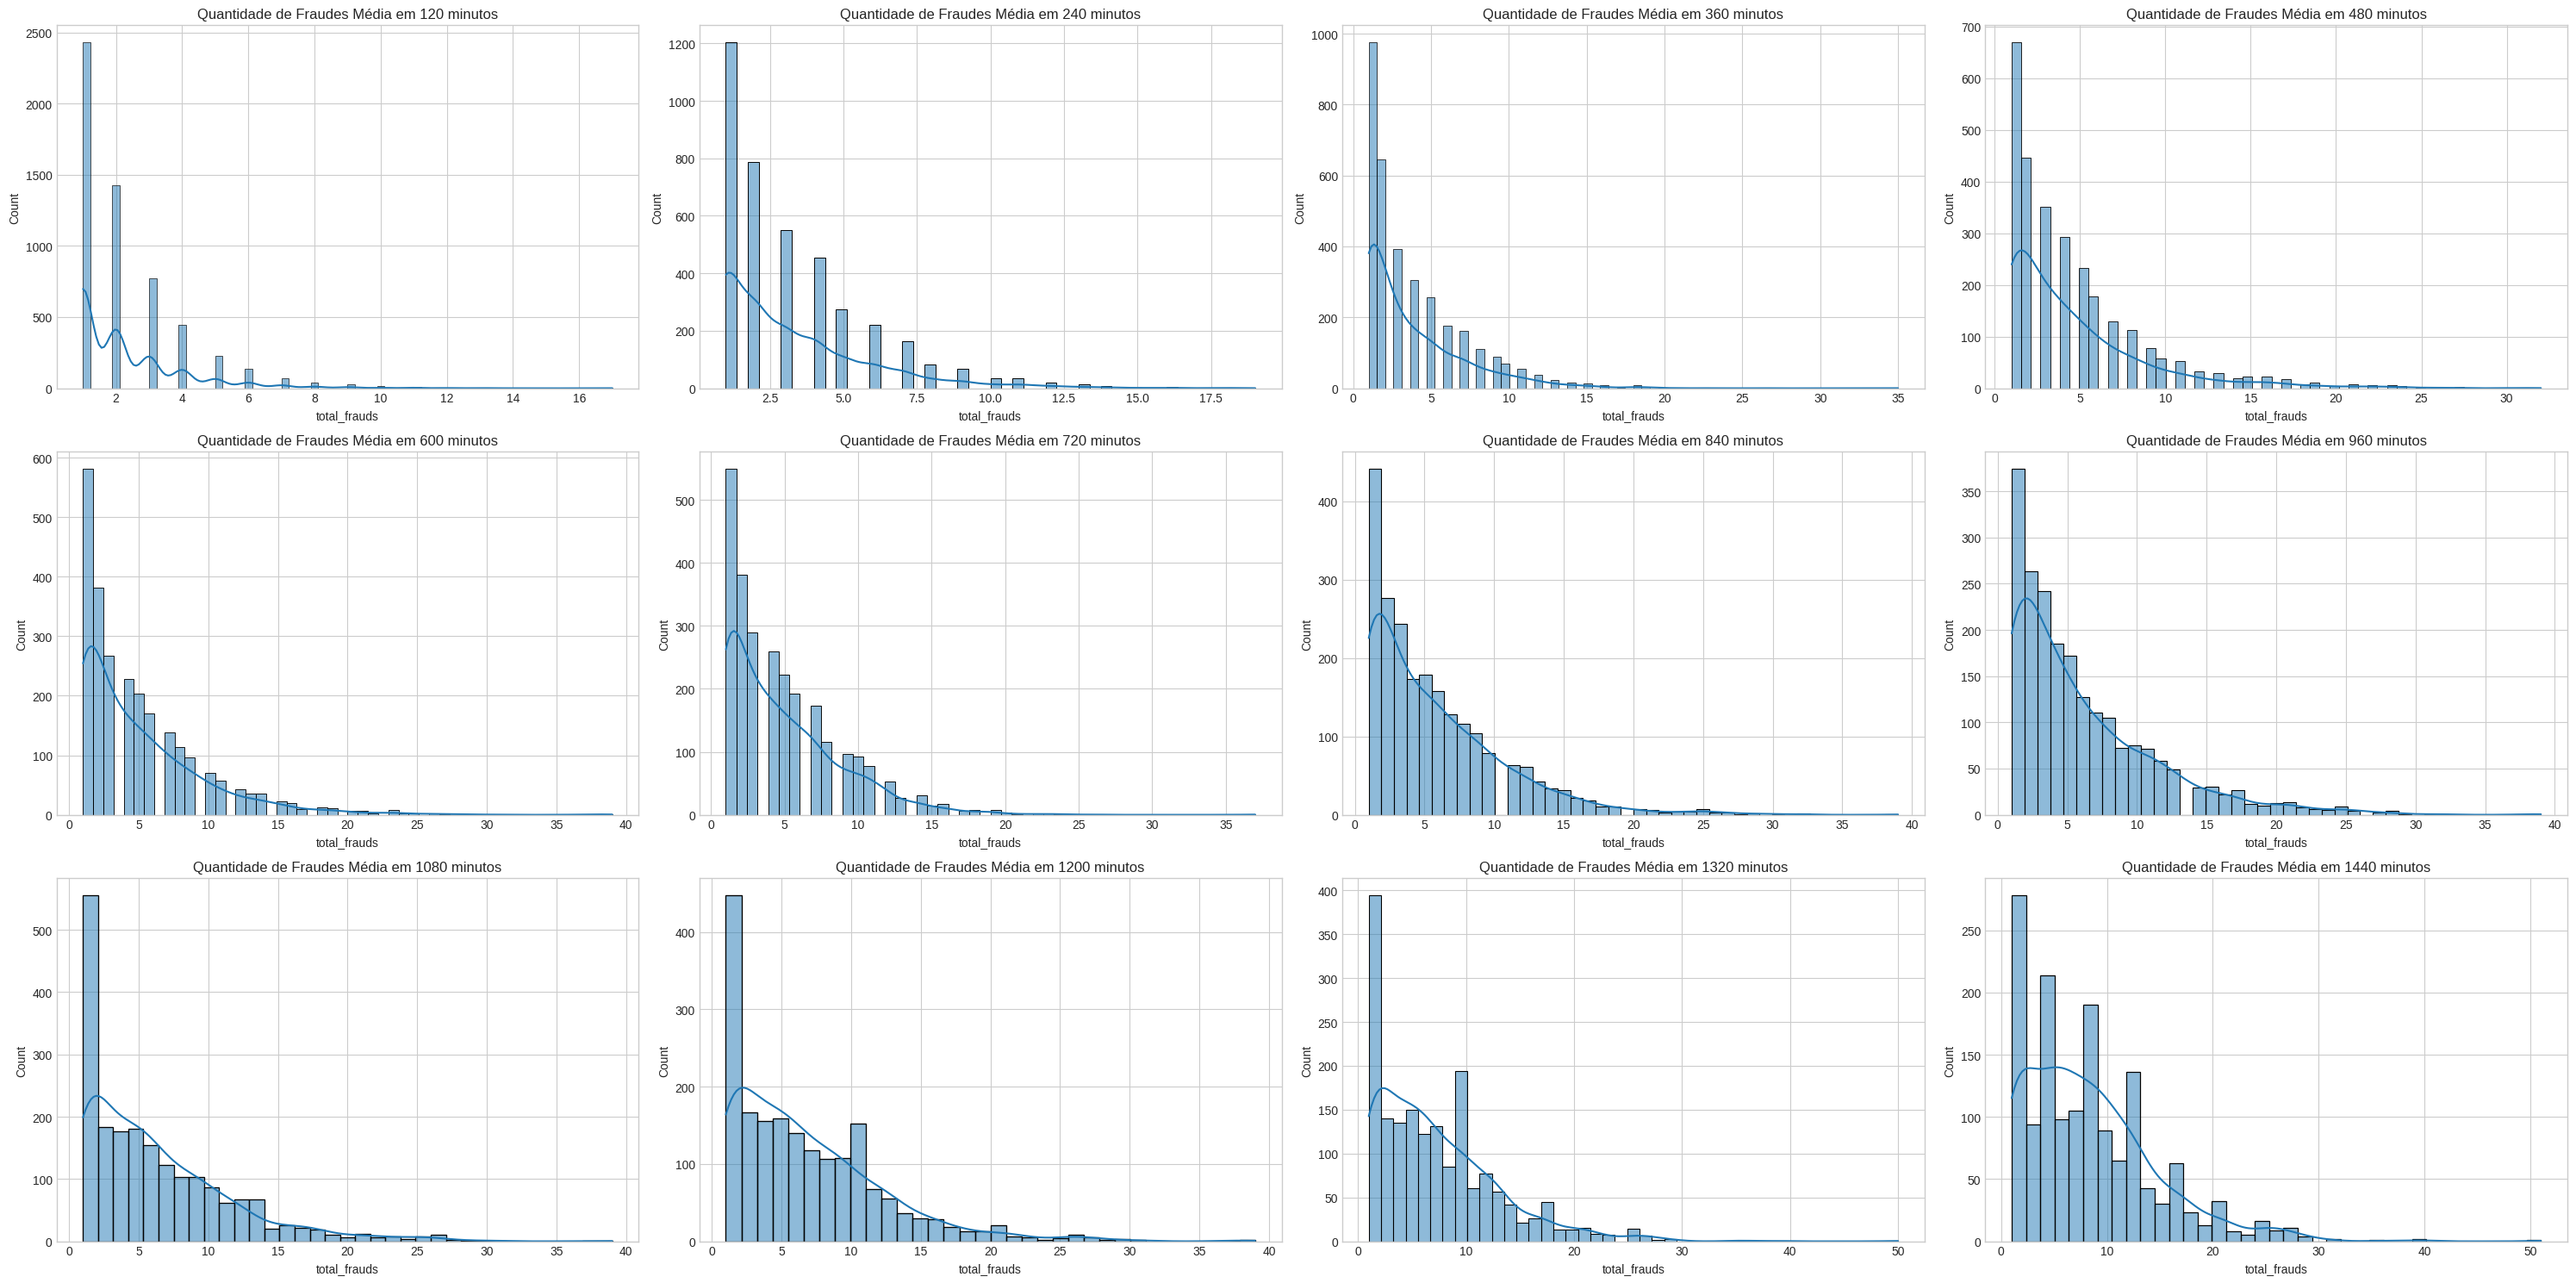

In [209]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440] #[15, 30, 60, 90, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 1440] # [240, 480, 720, 960]#
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

In [210]:
import numpy as np
import pandas as pd
import polars as pl
from typing import List, Set, Tuple, Optional

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

class WindowDataBuilder:
    """
    Builder class for creating time-windowed features for fraud detection.

    This class transforms raw transaction data into aggregated features
    organized by time windows, specifically designed for fraud detection models.
    """

    # Class constants for better maintainability
    CATEGORICAL_COLUMNS = ['city', 'country', 'description']
    DEFAULT_CORRELATION_THRESHOLD = 0.75
    DEFAULT_N_CLUSTERS = 3

    # Scale factors for feature normalization
    SCALE_FACTORS = {
        'amount': 1_000,
        'per_capita_income': 1_000,
        'total_debt': 10_000,
        'credit_score': 100,
        'credit_limit': 10_000,
    }

    def __init__(self, df: pl.DataFrame):
        """
        Initialize the WindowDataBuilder.

        Args:
            df (pl.DataFrame): Input DataFrame containing transaction data

        Raises:
            ValueError: If required columns are missing from the DataFrame
        """
        self._validate_input_data(df)
        self.df = df
        self._scaler = MinMaxScaler()

    def _validate_input_data(self, df: pl.DataFrame) -> None:
        """Validate that required columns exist in the input DataFrame."""
        required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def create_cluster_target_fields(
        self,
        df: pl.DataFrame,
        group_column_name: str,
        target_column_name: str,
        n_clusters: int = DEFAULT_N_CLUSTERS,
        drop_first: bool = False
    ) -> pl.DataFrame:
        """
        Create clustered categorical features based on target variable patterns.

        Args:
            df: Input DataFrame
            group_column_name: Column to group by
            target_column_name: Target variable column
            n_clusters: Number of clusters for KMeans
            drop_first: Whether to drop first dummy variable

        Returns:
            DataFrame with clustered dummy variables
        """
        try:
            # Define column names for better readability
            percent_target_col = f'percent_{target_column_name}'
            percent_no_target_col = f'percent_no_{target_column_name}'
            ab_col = 'ab'
            target_cluster_col = f'{target_column_name}_{group_column_name}'

            # Calculate target percentages by group
            df_cat_group = (
                df.group_by(group_column_name)
                .agg([
                    ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
                    (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
                ])
                .with_columns([
                    # Calculate A/B ratio with proper handling of edge cases
                    pl.when(pl.col(percent_no_target_col) == 0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
                    .alias(ab_col)
                ])
                .with_columns([
                    # Cap the A/B ratio at 100 for stability
                    pl.when(pl.col(ab_col) > 100.0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(ab_col))
                    .alias(ab_col)
                ])
            )

            # Apply clustering
            ab_values = df_cat_group.select(ab_col).to_pandas()
            scaled_values = self._scaler.fit_transform(ab_values)

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_values)

            # Add cluster labels and create dummy variables
            df_cat_group = df_cat_group.with_columns(
                pl.lit(cluster_labels).alias(target_cluster_col)
            )

            return (
                df_cat_group
                .select([group_column_name, target_cluster_col])
                .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
            )

        except Exception as e:
            raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

    def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
        """
        Generate statistical aggregations for a column.

        Args:
            column_name: Name of the column to generate statistics for
            divide_by: Scaling factor for normalization

        Returns:
            List of Polars expressions for statistical aggregations
        """
        return [
            (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
            (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
            (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
            (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
        ]

    def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Create base numerical features aggregated by time window.

        Args:
            df: Input DataFrame with date_window column

        Returns:
            DataFrame with aggregated numerical features
        """
        try:
            # Build aggregation expressions dynamically
            agg_expressions = [
                pl.col("target").sum().alias("frauds"),
                pl.col("target").count().alias("transactions"),
                pl.col("client_id").n_unique().alias("unique_clients"),
                pl.col("merchant_id").n_unique().alias("unique_merchants"),
                pl.col("amount").sum().alias("total_amount"),
            ]

            # Add statistical features for numerical columns
            for column, scale_factor in self.SCALE_FACTORS.items():
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, scale_factor)
                    )

            # Add statistics for columns without scaling
            for column in ['current_age', 'num_credit_cards']:
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, 1.0)
                    )

            # Perform aggregation
            df_features = (
                df.group_by("date_window")
                .agg(agg_expressions)
                .with_columns([
                    (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
                    (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
                ])
                .drop([
                    "transactions", "total_amount", "unique_clients", "unique_merchants"
                ] + [f"min_{col}" for col in ["amount"] if col in df.columns]
                  + [f"max_{col}" for col in ["amount"] if col in df.columns])
                .drop_nulls()
            )

            return df_features

        except Exception as e:
            raise RuntimeError(f"Error creating base features: {str(e)}")

    def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
        """
        Process categorical features and merge with base features.

        Args:
            df: Original DataFrame with categorical columns
            df_base: Base features DataFrame

        Returns:
            DataFrame with categorical and numerical features combined
        """
        result_df = df_base

        for column in self.CATEGORICAL_COLUMNS:
            if column not in df.columns:
                continue

            try:
                # Create cluster features for categorical column
                df_target_cat = self.create_cluster_target_fields(
                    df, column, 'target', drop_first=False
                )

                # Aggregate categorical features by time window
                df_with_cat = (
                    df.select(['date_window', column])
                    .join(df_target_cat, on=column, how='left')
                    .drop(column)
                    .group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are categorical features
                if len(df_with_cat.columns) > 1:
                    df_with_cat = df_with_cat.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_with_cat.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each categorical feature
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(col)
                        for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_with_cat = (
                            df_with_cat.with_columns(proportion_expressions)
                            .drop('total')
                        )

                    # Merge with result DataFrame
                    result_df = result_df.join(df_with_cat, on='date_window', how='left')

            except Exception as e:
                print(f"Warning: Error processing categorical column '{column}': {str(e)}")
                continue

        return result_df

    def _remove_highly_correlated_features(
        self,
        df: pd.DataFrame,
        threshold: float = DEFAULT_CORRELATION_THRESHOLD
    ) -> List[str]:
        """
        Identify features with high correlation for removal.

        Args:
            df: Input DataFrame
            threshold: Correlation threshold for removal

        Returns:
            List of column names to remove
        """
        try:
            if df.empty or len(df.columns) <= 1:
                return []

            # Calculate correlation matrix more efficiently
            corr_matrix = df.corr()

            # Create mask for upper triangle
            upper_triangle = np.triu(np.abs(corr_matrix), k=1)

            # Find highly correlated pairs
            high_corr_pairs = np.where(upper_triangle > threshold)
            columns_to_remove: Set[str] = set()

            # Process correlated pairs
            for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                # Skip if either column already marked for removal
                if col_i in columns_to_remove or col_j in columns_to_remove:
                    continue

                # Remove column with lower variance
                var_i = df[col_i].var()
                var_j = df[col_j].var()

                if pd.isna(var_i) or pd.isna(var_j):
                    continue

                if var_i < var_j:
                    columns_to_remove.add(col_i)
                else:
                    columns_to_remove.add(col_j)

            return list(columns_to_remove)

        except Exception as e:
            print(f"Warning: Error in correlation analysis: {str(e)}")
            return []

    def build(self, window: str) -> pd.DataFrame:
        """
        Build the complete feature dataset for the specified time window.

        Args:
            window: Time window specification (e.g., '1d', '1w', '1mo')

        Returns:
            pandas DataFrame with engineered features ready for modeling

        Raises:
            ValueError: If window specification is invalid
            RuntimeError: If feature engineering fails
        """
        try:
            if not isinstance(window, str) or not window.strip():
                raise ValueError("Window must be a non-empty string")

            # Create time windows
            df_windowed = self.df.with_columns(
                pl.col('date').dt.truncate(window).alias('date_window')
            )

            # Create base numerical features
            df_base = self._create_base_features(df_windowed)

            # Process categorical features
            df_with_categories = self._process_categorical_features(df_windowed, df_base)

            # Convert to pandas for correlation analysis
            df_pandas = df_with_categories.to_pandas()

            # Remove highly correlated features
            columns_to_remove = self._remove_highly_correlated_features(
                df_pandas.drop(columns=['date_window'], errors='ignore')
            )

            if columns_to_remove:
                df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
                print(f"Removed {len(columns_to_remove)} highly correlated features")

            return df_pandas.sort_values('date_window')

        except Exception as e:
            raise RuntimeError(f"Error building features: {str(e)}")

    def get_feature_info(self) -> dict:
        """
        Get information about the feature engineering process.

        Returns:
            Dictionary with feature engineering configuration
        """
        return {
            'categorical_columns': self.CATEGORICAL_COLUMNS,
            'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
            'n_clusters': self.DEFAULT_N_CLUSTERS,
            'scale_factors': self.SCALE_FACTORS,
        }

In [211]:
window_data_builder = WindowDataBuilder(df)

In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson, nbinom

class BaselineCoutingModel:
  def __init__(self, df: pd.DataFrame, window: str):
    self.df = df
    self.models= []
    self.window = window
    # Adicione um mapeamento de nomes para facilitar a plotagem
    self.model_name_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial': self._plot_neg_binomial_dist, # Assumindo que Binomial na verdade é Binomial Negativa
        'Zip': self._plot_zip_dist,
        'Zimb': self._plot_zinb_dist,
    }

  # --- MÉTODOS DE TREINO (sem alterações) ---
  def train_poisson(self):
    return smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson()).fit()

  def train_binomial(self): # Este método treina um Binomial Negativo
    return sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df).fit(disp=False, maxiter=1000)

  def train_zip(self):
    return sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train_zimb(self):
    return sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train(self):
    # Ajustei os nomes para corresponder à implementação e ao gráfico desejado
    models = {'Poisson': self.train_poisson,
              'Binomial Negativa': self.train_binomial,
              'ZIP': self.train_zip,
              'ZINB': self.train_zimb}

    for model_name, action in models.items():
      print(f'Training BASELINE {model_name} with window {self.window}')
      try:
        model = action()
        self.models.append(dict(name=model_name, model=model))
      except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
    print('Baseline Models Trained')

  # --- MÉTODO DE RELATÓRIO (sem alterações) ---
  def get_report(self) -> pd.DataFrame:
    # ... (código do get_report como na resposta anterior)
    metrics = []
    for model in self.models:
      model_name = model.get('name')
      model_trained = model.get('model')
      rmse_resid = np.sqrt(np.mean(model_trained.resid_pearson**2))
      outliers = np.sum(np.abs(model_trained.resid_pearson) > 2)
      metric = dict(window=self.window, model_name=model_name, LLF=model_trained.llf, BIC=model_trained.bic, AIC=model_trained.aic, Converged=model_trained.converged)
      if hasattr(model_trained, 'prsquared'):
        metric['PseudoR2'] = model_trained.prsquared
      elif hasattr(model_trained, 'pseudo_rsquared'):
         metric['PseudoR2'] = model_trained.pseudo_rsquared()
      else:
         metric['PseudoR2'] = 0.0
      metric['RMSE_Pearson'] = rmse_resid
      metric['Outliers'] = outliers
      metrics.append(metric)
    return pd.DataFrame(metrics)

  # --- NOVO MÉTODO DE PLOTAGEM ---
  def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
    """
    Plota a distribuição observada vs. as distribuições teóricas dos modelos treinados.
    """
    if not self.models:
        print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
        return

    y = self.df[target_col]
    max_fraudes = int(y.max())
    bins = np.arange(0, max_fraudes + 2)
    total_obs = len(y)

    plt.style.use('seaborn-v0_8-whitegrid') # Estilo similar ao da imagem
    plt.figure(figsize=fig_size) # Tamanho maior para melhor visualização

    # 1. Plota a distribuição observada
    ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', alpha=0.6, label='Observado')

    # 2. Plota a curva de cada modelo treinado
    plot_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial Negativa': self._plot_neg_binomial_dist,
        'ZIP': self._plot_zip_dist,
        'ZINB': self._plot_zinb_dist
    }

    for model_info in self.models:
        model_name = model_info['name']
        model_trained = model_info['model']

        if model_name in plot_map:
            plot_map[model_name](ax, model_trained, bins, total_obs)

    # 3. Finaliza o gráfico
    ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
    ax.set_xlabel('Fraudes', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
    plt.tight_layout()
    plt.show()

  # --- MÉTODOS AUXILIARES PARA PLOTAGEM ---
  def _plot_poisson_dist(self, ax, model, bins, total_obs):
    lambda_poisson = np.exp(model.params['Intercept'])
    poisson_freq = poisson.pmf(bins[:-1], lambda_poisson) * total_obs
    ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

  def _plot_neg_binomial_dist(self, ax, model, bins, total_obs):
    mu_negbin = np.exp(model.params['Intercept'])
    alpha_negbin = model.params.get('alpha', getattr(model, 'scale', None)) # Compatibilidade
    if alpha_negbin is None: return

    n = 1 / alpha_negbin
    p = n / (n + mu_negbin)
    negbin_freq = nbinom.pmf(bins[:-1], n=n, p=p) * total_obs
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)

  def _plot_zip_dist(self, ax, model, bins, total_obs):
    lambda_zip = np.exp(model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-model.params['inflate_const']))

    zip_pmf = (1 - pi_zip) * poisson.pmf(bins[:-1], lambda_zip)
    zip_pmf[0] = pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)
    zip_freq = zip_pmf * total_obs
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)

  def _plot_zinb_dist(self, ax, model, bins, total_obs):
    mu_zinb = np.exp(model.params['Intercept'])
    alpha_zinb = model.params['alpha']
    pi_zinb = 1 / (1 + np.exp(-model.params['inflate_const']))

    n = 1 / alpha_zinb
    p = n / (n + mu_zinb)

    zinb_pmf = (1 - pi_zinb) * nbinom.pmf(bins[:-1], n=n, p=p)
    zinb_pmf[0] = pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n, p=p)
    zinb_freq = zinb_pmf * total_obs
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)

In [221]:
%%time

builders = []

for minute in tqdm.tqdm(minutes, desc='Validando periodos'):
  df_train = window_data_builder.build(f'{minute}m')

  builder = BaselineCoutingModel(df_train, f'{minute}m')
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/12 [00:00<?, ?it/s]

Removed 8 highly correlated features
Training BASELINE Poisson with window 120m
Training BASELINE Binomial Negativa with window 120m
Training BASELINE ZIP with window 120m
Training BASELINE ZINB with window 120m


Validando periodos:   8%|▊         | 1/12 [00:18<03:18, 18.08s/it]

Baseline Models Trained
Removed 8 highly correlated features
Training BASELINE Poisson with window 240m
Training BASELINE Binomial Negativa with window 240m
Training BASELINE ZIP with window 240m
Training BASELINE ZINB with window 240m


Validando periodos:  17%|█▋        | 2/12 [00:26<02:02, 12.26s/it]

Baseline Models Trained
Removed 10 highly correlated features
Training BASELINE Poisson with window 360m
Training BASELINE Binomial Negativa with window 360m
Training BASELINE ZIP with window 360m
Training BASELINE ZINB with window 360m


Validando periodos:  25%|██▌       | 3/12 [00:31<01:20,  8.96s/it]

Baseline Models Trained
Removed 10 highly correlated features
Training BASELINE Poisson with window 480m
Training BASELINE Binomial Negativa with window 480m
Training BASELINE ZIP with window 480m
Training BASELINE ZINB with window 480m


Validando periodos:  33%|███▎      | 4/12 [00:35<00:55,  6.98s/it]

Baseline Models Trained
Removed 8 highly correlated features
Training BASELINE Poisson with window 600m
Training BASELINE Binomial Negativa with window 600m
Training BASELINE ZIP with window 600m
Training BASELINE ZINB with window 600m


Validando periodos:  42%|████▏     | 5/12 [00:39<00:42,  6.07s/it]

Baseline Models Trained
Removed 7 highly correlated features
Training BASELINE Poisson with window 720m
Training BASELINE Binomial Negativa with window 720m
Training BASELINE ZIP with window 720m
Training BASELINE ZINB with window 720m


Validando periodos:  50%|█████     | 6/12 [00:43<00:31,  5.20s/it]

Baseline Models Trained
Removed 9 highly correlated features
Training BASELINE Poisson with window 840m
Training BASELINE Binomial Negativa with window 840m
Training BASELINE ZIP with window 840m
Training BASELINE ZINB with window 840m


Validando periodos:  58%|█████▊    | 7/12 [00:46<00:22,  4.53s/it]

Baseline Models Trained
Removed 10 highly correlated features
Training BASELINE Poisson with window 960m
Training BASELINE Binomial Negativa with window 960m
Training BASELINE ZIP with window 960m
Training BASELINE ZINB with window 960m


Validando periodos:  67%|██████▋   | 8/12 [00:49<00:16,  4.15s/it]

Baseline Models Trained
Removed 9 highly correlated features
Training BASELINE Poisson with window 1080m
Training BASELINE Binomial Negativa with window 1080m
Training BASELINE ZIP with window 1080m
Training BASELINE ZINB with window 1080m


Validando periodos:  75%|███████▌  | 9/12 [00:52<00:11,  3.74s/it]

Baseline Models Trained
Removed 9 highly correlated features
Training BASELINE Poisson with window 1200m
Training BASELINE Binomial Negativa with window 1200m
Training BASELINE ZIP with window 1200m
Training BASELINE ZINB with window 1200m


Validando periodos:  83%|████████▎ | 10/12 [00:55<00:07,  3.54s/it]

Baseline Models Trained
Removed 9 highly correlated features
Training BASELINE Poisson with window 1320m
Training BASELINE Binomial Negativa with window 1320m
Training BASELINE ZIP with window 1320m
Training BASELINE ZINB with window 1320m


Validando periodos:  92%|█████████▏| 11/12 [00:58<00:03,  3.48s/it]

Baseline Models Trained
Removed 10 highly correlated features
Training BASELINE Poisson with window 1440m
Training BASELINE Binomial Negativa with window 1440m
Training BASELINE ZIP with window 1440m
Training BASELINE ZINB with window 1440m


Validando periodos: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

Baseline Models Trained
CPU times: user 5min 58s, sys: 17.6 s, total: 6min 16s
Wall time: 1min 2s


In [222]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=True)
df_report.reset_index(drop=True, inplace=True)
df_report

,window,model_name,LLF,BIC,AIC,Converged,PseudoR2,RMSE_Pearson,Outliers
0,120m,Poisson,-36273.604984,-401387.909697,72549.209969,True,0.000000e+00,1.820327,3183
1,240m,Poisson,-30830.871549,-164337.621400,61663.743097,True,0.000000e+00,2.171882,1940
2,360m,Poisson,-27657.000514,-91942.236354,55316.001029,True,0.000000e+00,2.417245,1736
3,120m,ZIP,-26062.748669,52146.838596,52129.497339,True,-3.681522e-10,1.113878,1756
4,480m,Poisson,-26019.234583,-56528.888767,52040.469165,True,0.000000e+00,2.703015,1328
5,120m,Binomial Negativa,-25576.987256,51175.315768,51157.974512,True,5.846101e-11,0.925697,1756
6,600m,Poisson,-24092.703356,-37895.525961,48187.406711,True,8.881784e-16,2.777668,1309
7,840m,Poisson,-20865.122440,-19295.304037,41732.244881,True,0.000000e+00,2.817431,1100
8,720m,Poisson,-20782.606047,-30500.028095,41567.212094,True,0.000000e+00,2.496118,1148
9,960m,Poisson,-19912.276693,-13436.164987,39826.553386,True,-1.332268e-15,2.912284,868


In [223]:
df_report_filter = df_report[df_report.LLF.notna()].groupby('window').agg(count=('window', 'count'), llf=('LLF', 'median'))
df_report_filter.query('count == 4', inplace=True)
df_report_filter.sort_values(by=['llf'], ascending=False, inplace=True)
df_report_filter.reset_index(inplace=True)
df_report_filter

,window,count,llf
0,1320m,4,-8740.110305
1,1200m,4,-9198.604172
2,1080m,4,-9830.479736
3,960m,4,-10447.372246
4,840m,4,-10987.786173
5,720m,4,-11974.581516
6,480m,4,-13915.026582
7,360m,4,-16000.923081


In [224]:
selected_builder = list(filter(lambda x: x.window == df_report_filter.loc[0, 'window'], builders))[0]
selected_builder.get_report()

,window,model_name,LLF,BIC,AIC,Converged,PseudoR2,RMSE_Pearson,Outliers
0,1320m,Poisson,-17000.405132,-4632.287066,34002.810264,True,0.000000e+00,2.913430,823
1,1320m,Binomial Negativa,-8032.608697,16081.764068,16069.217395,True,3.312917e-11,0.762934,99
2,1320m,ZIP,-9447.611913,18911.770499,18899.223826,True,5.752510e-12,1.303277,353
3,1320m,ZINB,-7813.706704,15652.233418,15633.413408,True,3.171319e-11,0.978462,177


<Figure size 1200x800 with 0 Axes>

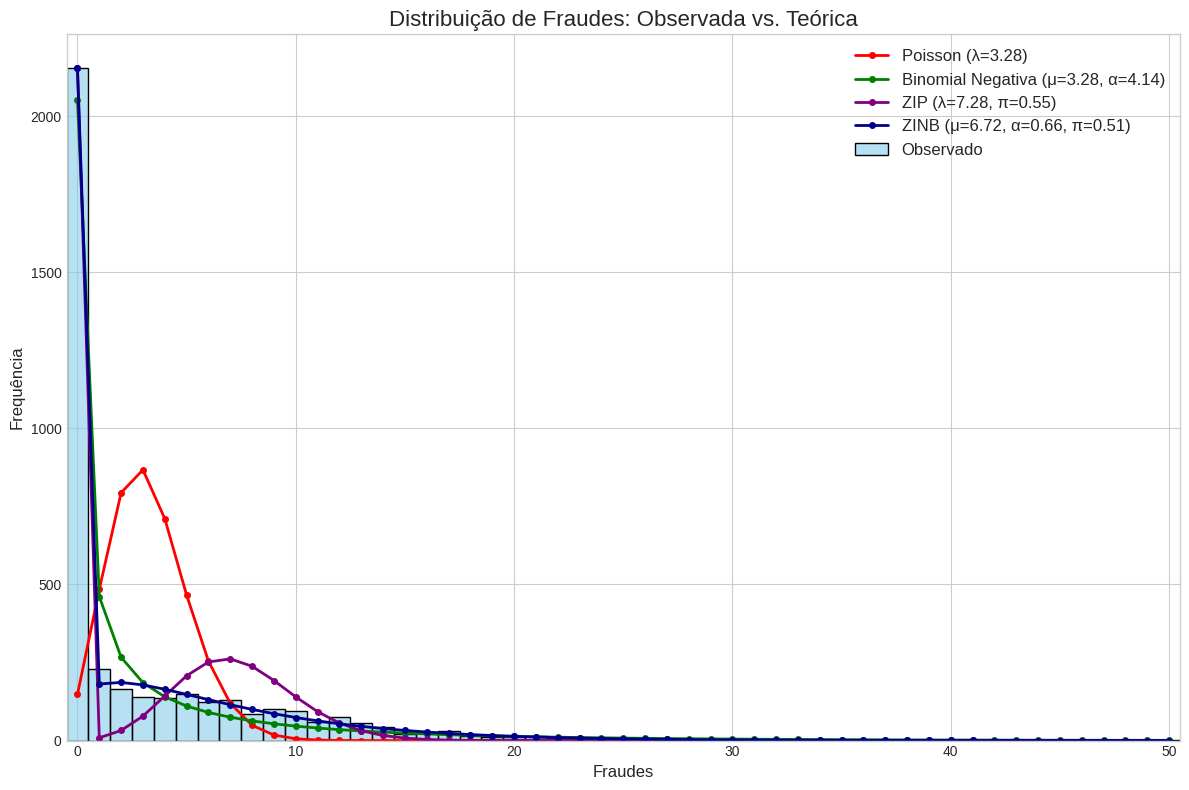

In [225]:
selected_builder.plot_theoretical_distributions()

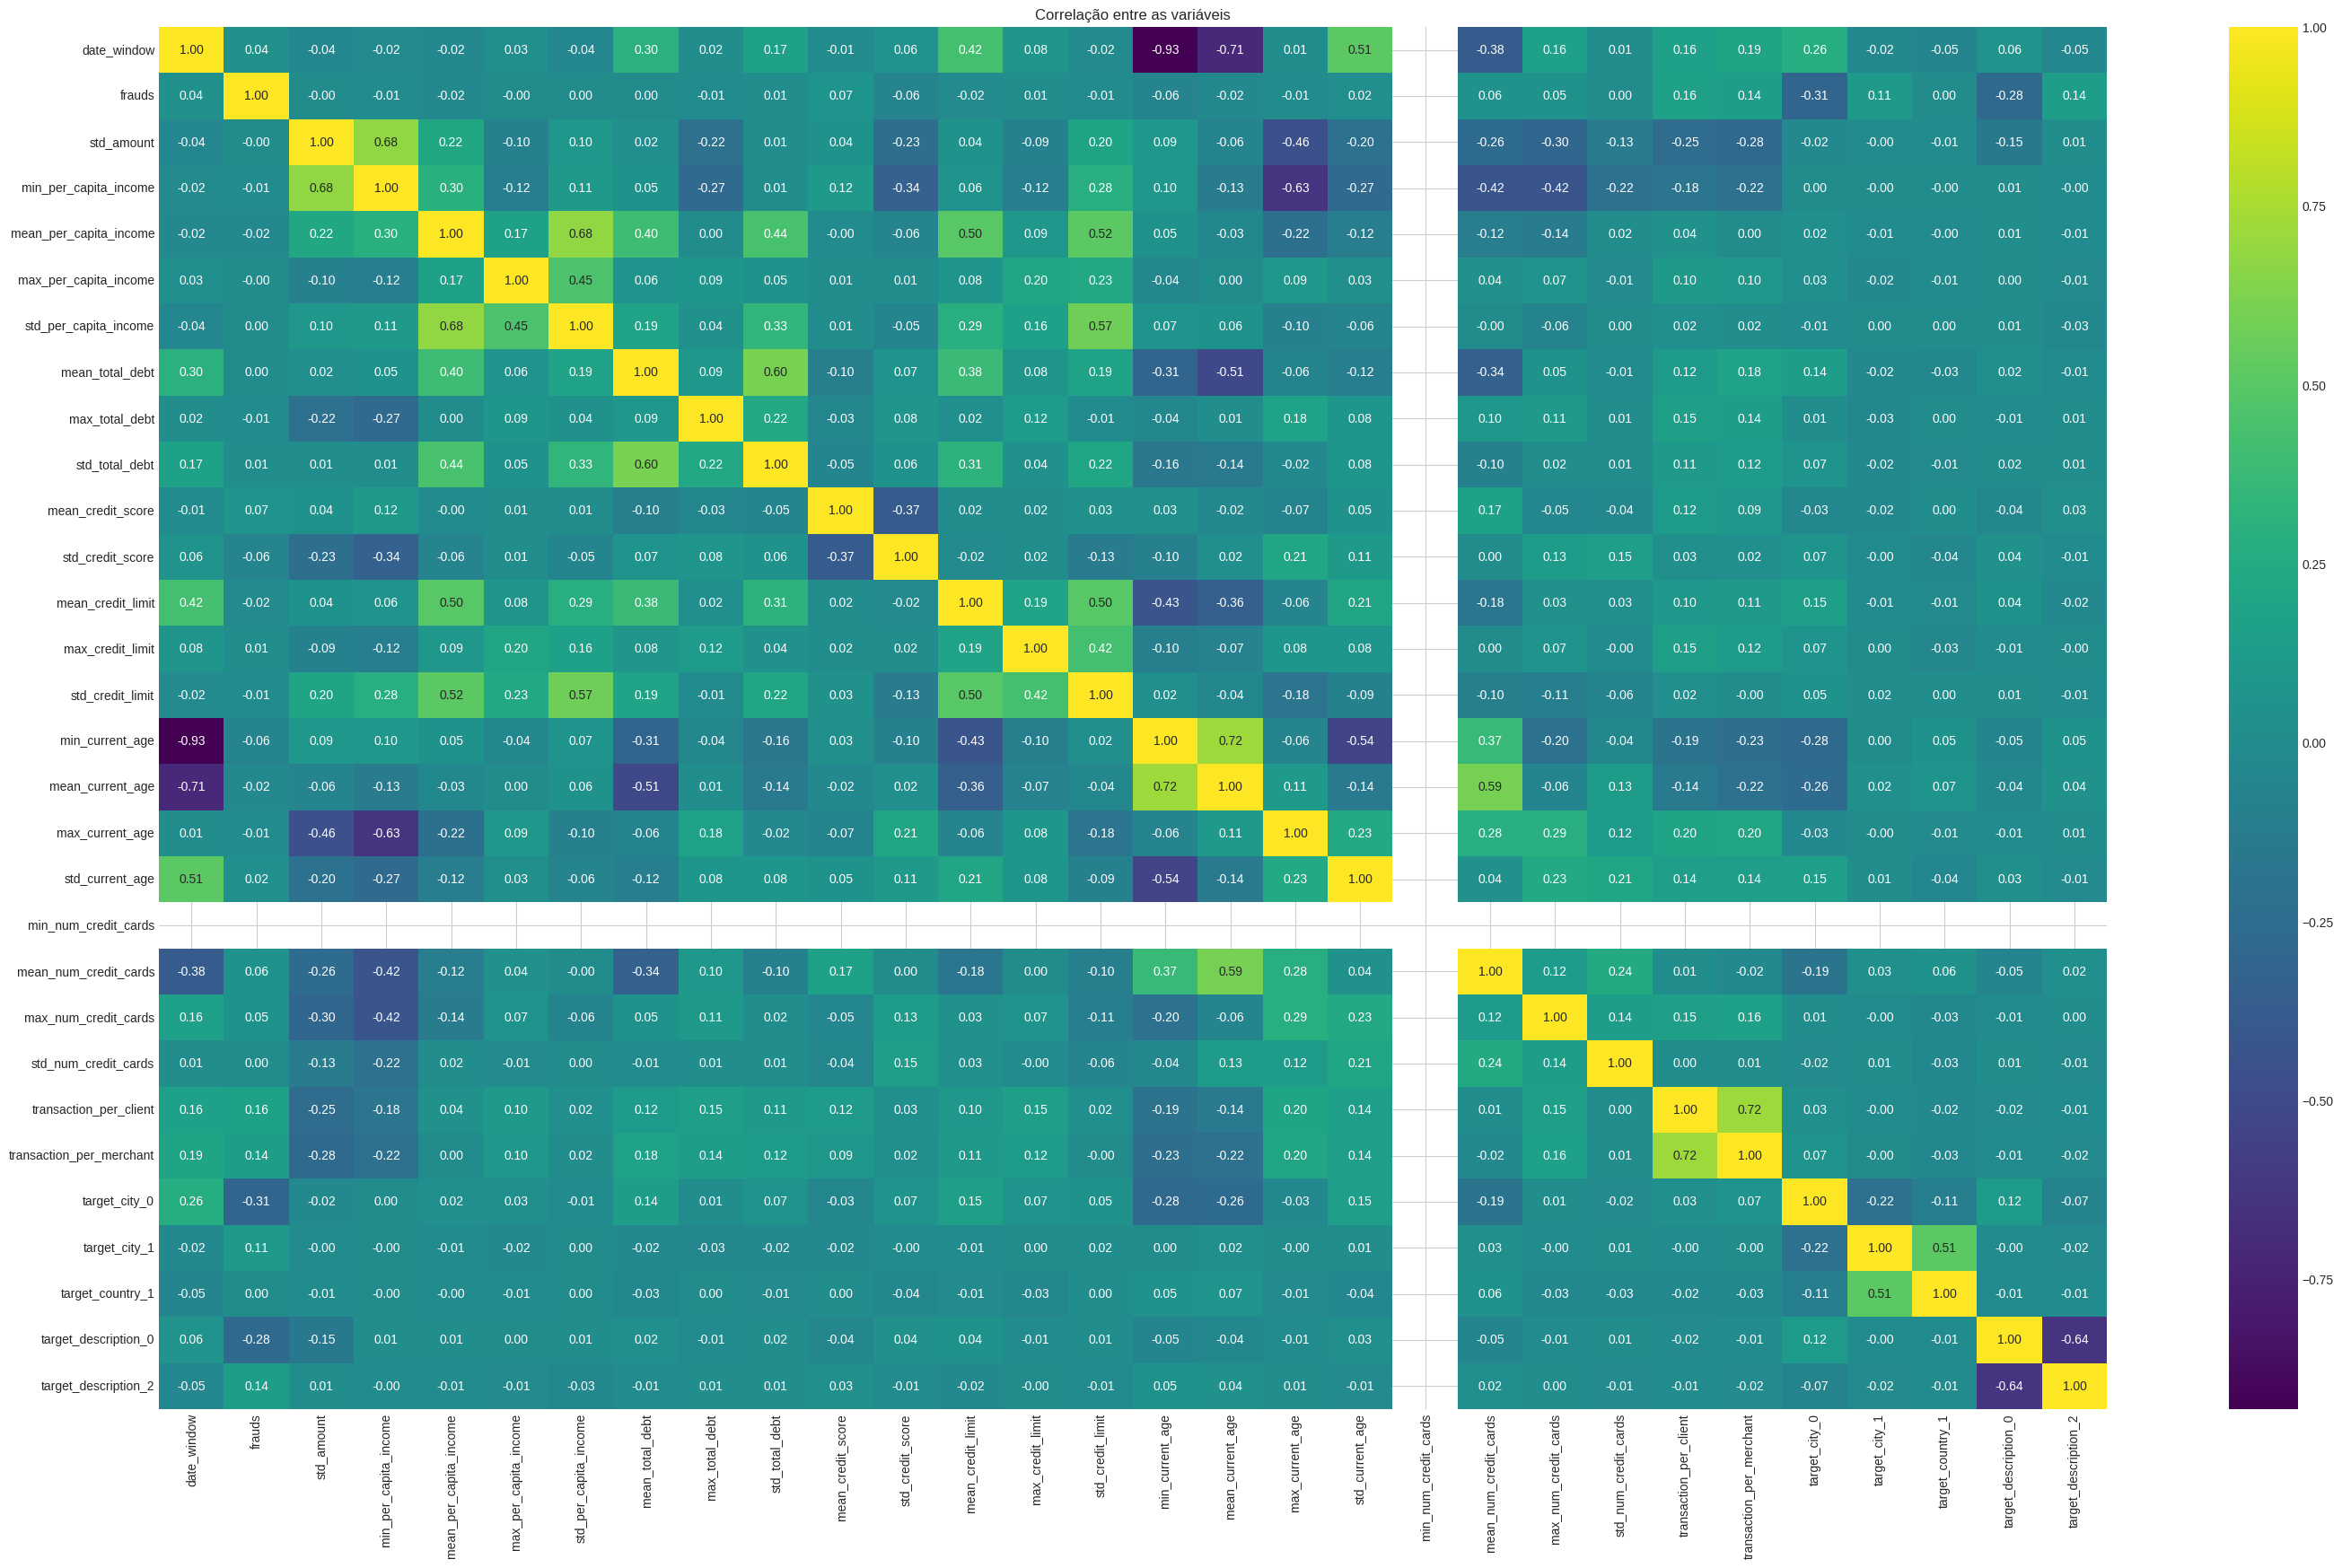

In [226]:
corr_before_removed = selected_builder.df.corr()
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr_before_removed, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [231]:
selected_builder.df

,date_window,frauds,std_amount,min_per_capita_income,mean_per_capita_income,max_per_capita_income,std_per_capita_income,mean_total_debt,max_total_debt,std_total_debt,...,mean_num_credit_cards,max_num_credit_cards,std_num_credit_cards,transaction_per_client,transaction_per_merchant,target_city_0,target_city_1,target_country_1,target_description_0,target_description_2
209,2009-12-31 20:00:00,0,0.070371,0.0,24.028357,163.145,12.162995,5.575113,46.1854,5.170211,...,3.932788,9.0,1.555460,2.154912,2.980836,1.0,0.0,0.0,1.000000,0.000000
1394,2010-01-01 18:00:00,1,0.078846,0.0,24.206268,163.145,13.252244,5.480367,46.1854,4.915029,...,3.904894,9.0,1.561704,2.163658,2.644118,1.0,0.0,0.0,1.000000,0.000000
2375,2010-01-02 16:00:00,0,0.065641,0.0,23.574236,163.145,11.398196,5.786568,46.1854,5.348577,...,3.930055,9.0,1.551917,2.170819,2.703102,1.0,0.0,0.0,1.000000,0.000000
2473,2010-01-03 14:00:00,1,0.066271,0.0,23.427030,137.428,10.588153,5.493292,46.1854,5.039364,...,3.944149,9.0,1.585783,2.196262,2.923795,1.0,0.0,0.0,1.000000,0.000000
3844,2010-01-04 12:00:00,3,0.092280,0.0,23.243778,163.145,10.583703,5.520489,46.1854,4.853271,...,3.898344,9.0,1.559836,2.109639,2.801600,1.0,0.0,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,2019-10-27 18:00:00,0,0.065195,0.0,23.975364,163.145,11.986145,5.872298,46.1854,5.506492,...,3.863393,9.0,1.570183,2.260343,2.821159,1.0,0.0,0.0,1.000000,0.000000
3036,2019-10-28 16:00:00,0,0.097728,0.0,24.330313,137.428,11.846124,5.947213,46.1854,5.409470,...,3.870025,9.0,1.557446,2.164667,2.856115,1.0,0.0,0.0,0.999496,0.000504
3710,2019-10-29 14:00:00,0,0.062996,0.0,23.729245,137.428,10.994094,5.805216,46.1854,5.215575,...,3.872063,9.0,1.596046,2.095186,2.623288,1.0,0.0,0.0,1.000000,0.000000
942,2019-10-30 12:00:00,0,0.072354,0.0,24.173224,163.145,12.525309,5.867574,46.1854,5.539682,...,3.910588,9.0,1.612541,2.208940,2.659574,1.0,0.0,0.0,0.999529,0.000471


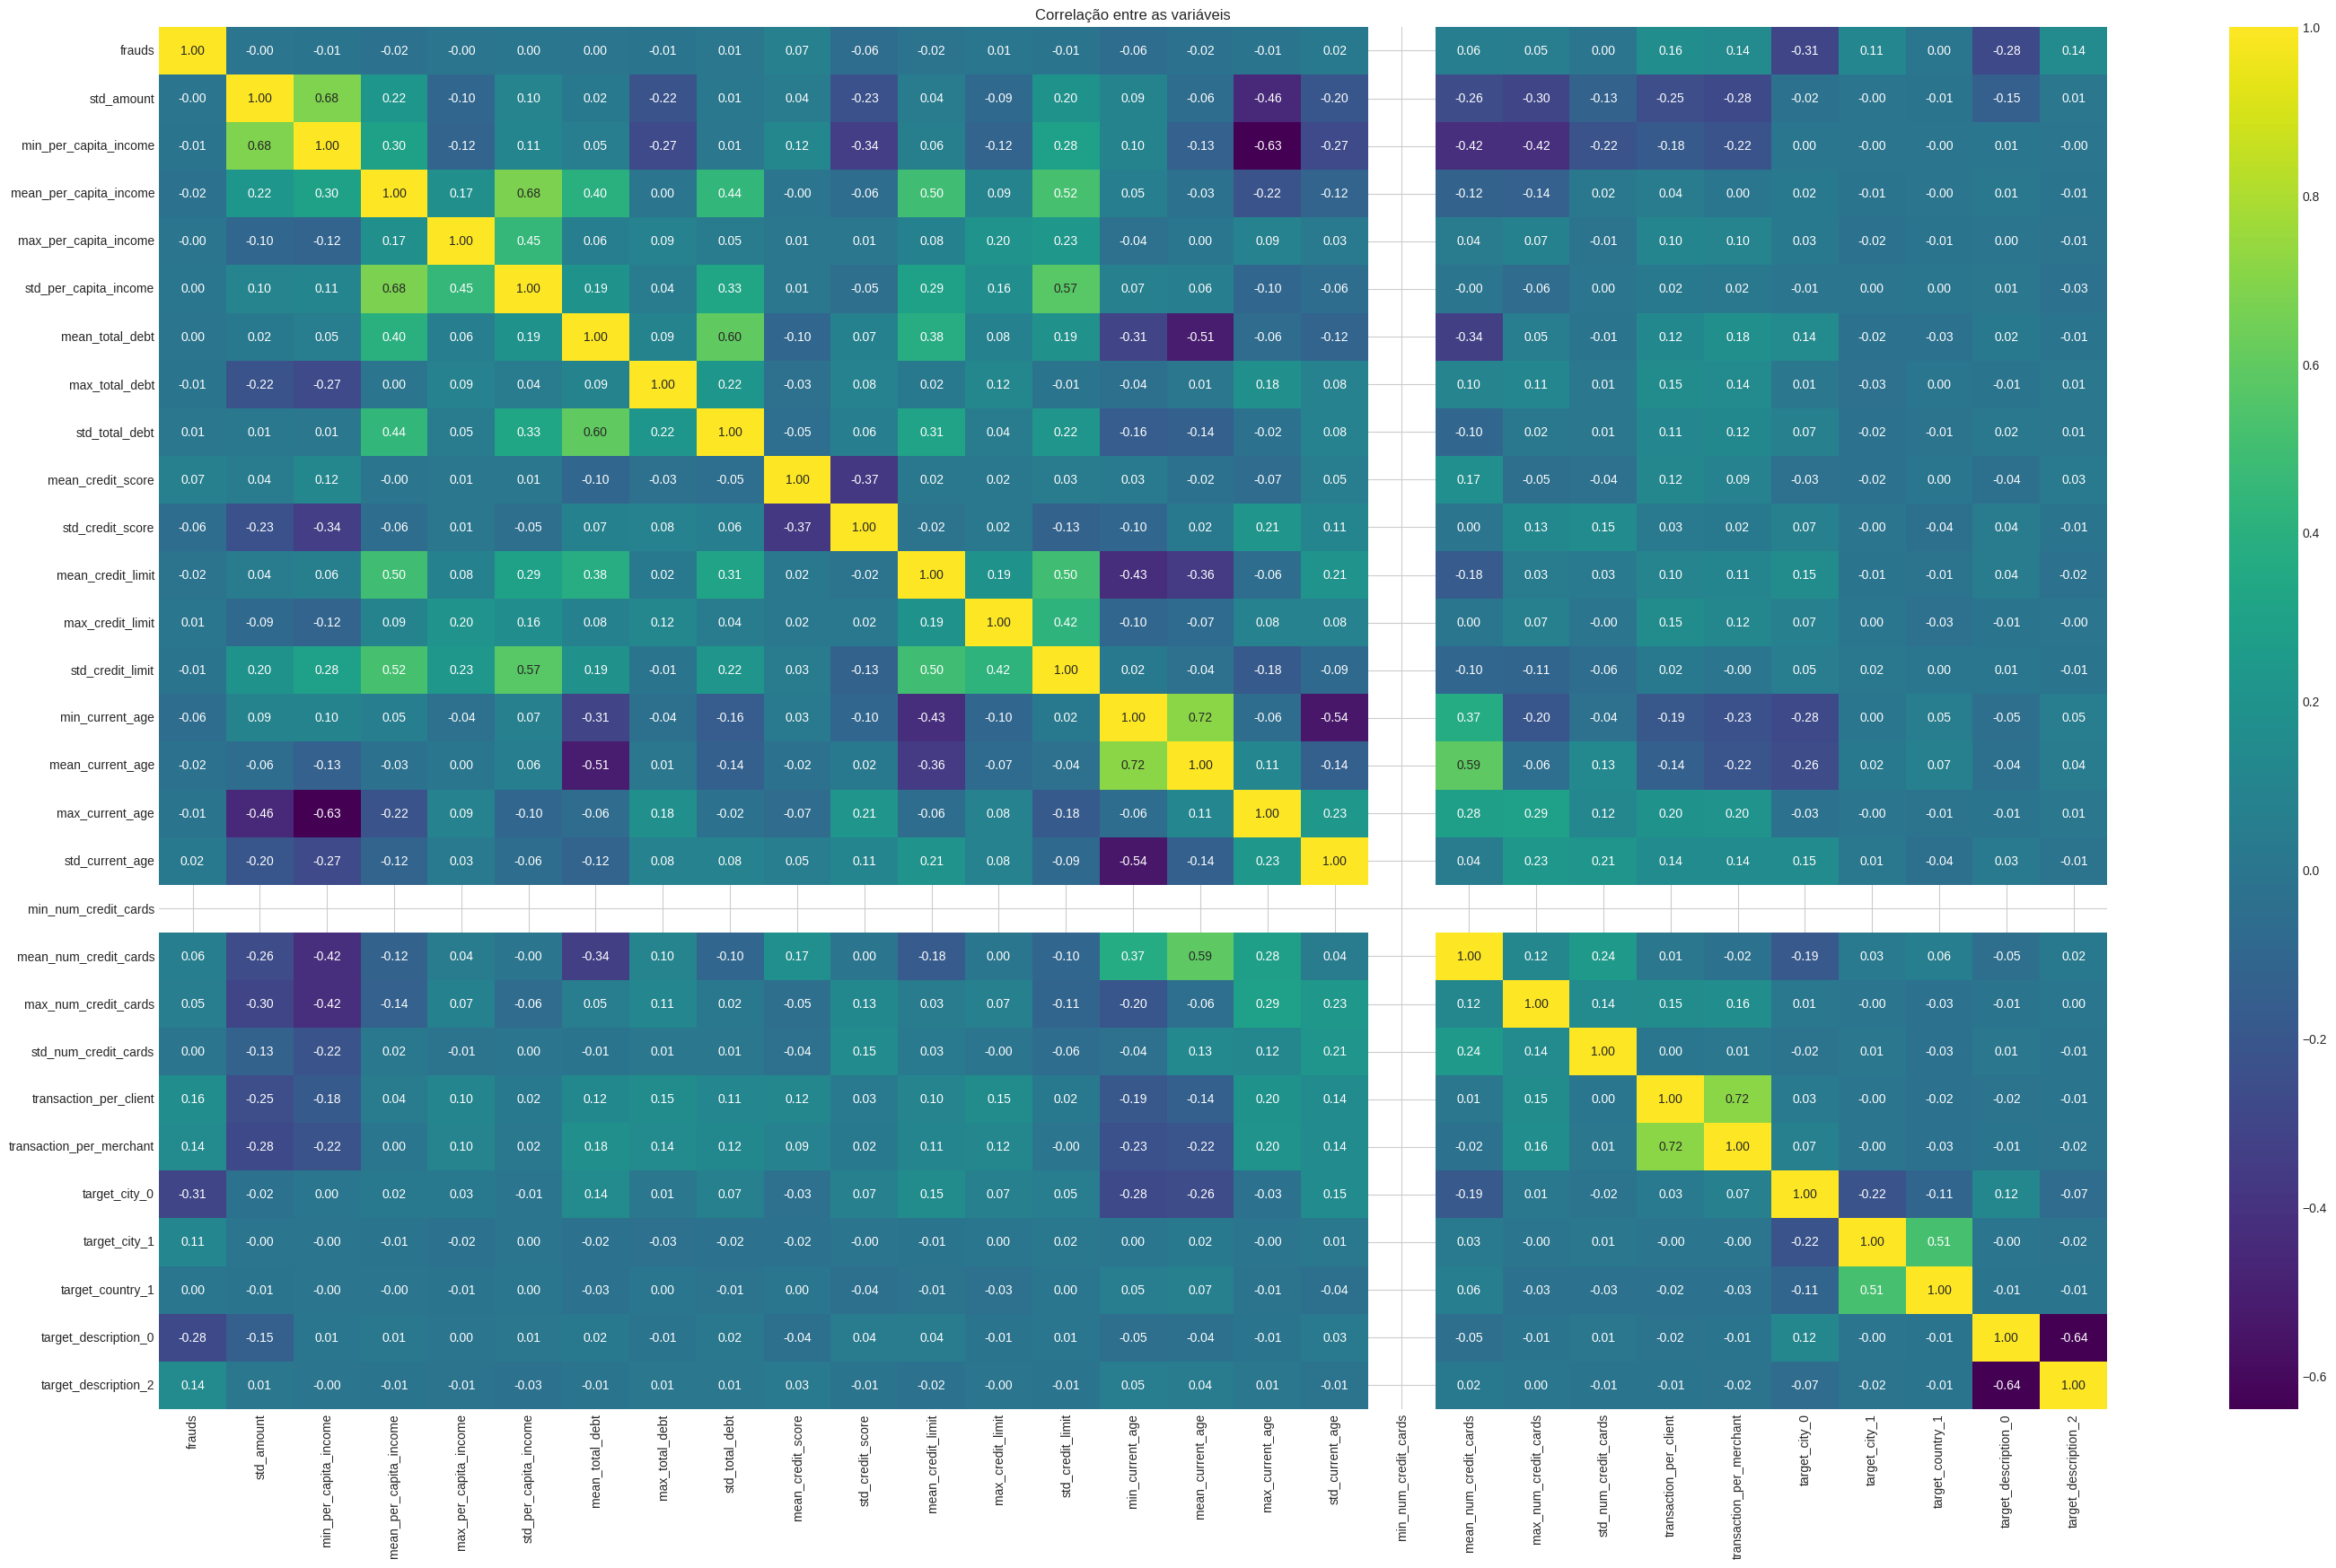

In [233]:
corr =  selected_builder.df.corr(numeric_only=True)

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()